## Animal Classification

Name: Adrienne Fernanedez

Dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10

**Note: Please upload the file downloaded from the link which is "archive.zip"**

---



## Libraries

In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import splitfolders

2024-12-18 12:56:01.659155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734555361.770504  504182 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734555361.802377  504182 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 12:56:02.054607: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

In [3]:
#dataset has to be uploaded as a zip to make it easier to be uploaded to google colab
!unzip ./archive.zip

In [4]:
data_file = 'raw-img'
splitfolders.ratio(data_file, output = 'animals', seed = 42, ratio = (.7, .2, .1)) #split dataset: 70% for train, 20% for validation, and 10% test

In [5]:
classes = [ "Dog", "Horse" ,  "Elephant", "Butterfly", "Chicken",  "Cat", "Cow", "Sheep", "Spider", "Squirrel"]
img_height, img_width = 224, 224
batch_size = 48

## Training Dataset Extraction

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    'animals/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

Found 18322 files belonging to 10 classes.


I0000 00:00:1734555371.161592  504182 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## Validation Dataset Extraction

In [7]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    'animals/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=42,
)

Found 5232 files belonging to 10 classes.


## Testing Dataset Extaction

In [8]:

test_ds = tf.keras.utils.image_dataset_from_directory(
    'animals/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    shuffle=False,
    batch_size = None,
    seed=42,
)
#shuffle the dataset only once before putting in batch of 32
test_ds = test_ds.shuffle(len(test_ds), seed = 42, reshuffle_each_iteration = False)
test_ds = test_ds.batch(32)



Found 2625 files belonging to 10 classes.


## Visualize Image From Training Dataset

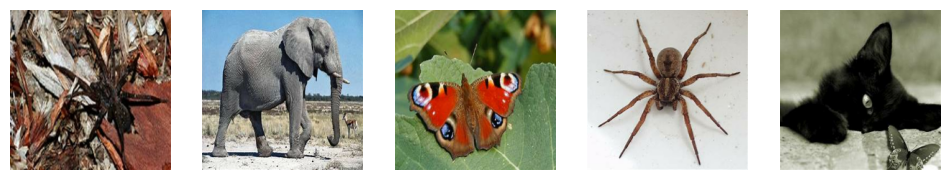

In [9]:
img, label = next(train_ds.as_numpy_iterator())
plt.figure(figsize=(12, 12))
for i in range(5):
    plt.subplot(1,5, i + 1)
    plt.imshow(img[i].astype('uint8'))
    plt.axis('off')
plt.show()

# Neural Network

In [10]:
#regulization parameter
lam = 0.00008

In [11]:
#data augmentation
augementation =  keras.Sequential(
    [
        keras.layers.RandomZoom(0.3),
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomBrightness((-0.2, 0.2)),
        keras.layers.RandomTranslation(0.1, 0.1),
        keras.layers.RandomContrast(0.3),
    ]

)

## Model Architecture

In [12]:
cnn = keras.models.Sequential()
cnn.add(keras.Input(shape= (img_height, img_width, 3)))
cnn.add(augementation)
cnn.add(keras.layers.GaussianNoise(0.5))
cnn.add(keras.layers.Conv2D(filters = 64, kernel_size = 11, strides = 2, padding = 'same', activation = 'relu'))
cnn.add(keras.layers.MaxPool2D(pool_size = 2, strides = 2))
cnn.add(keras.layers.Conv2D(filters = 128, kernel_size = 5, padding = 'valid', activation = 'relu'))
cnn.add(keras.layers.Conv2D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
cnn.add(keras.layers.MaxPool2D(pool_size = 2, strides = 2))
cnn.add(keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'valid', activation = 'relu'))
cnn.add(keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(keras.layers.MaxPool2D(pool_size = 2, strides = 2))
cnn.add(keras.layers.Conv2D(filters = 384, kernel_size = 3, padding = 'valid', activation = 'relu'))
cnn.add(keras.layers.Conv2D(filters = 384, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(keras.layers.Conv2D(filters = 640, kernel_size = 3, padding = 'same', activation = 'relu'))
cnn.add(keras.layers.MaxPool2D(pool_size = 8, strides = 2))
cnn.add(keras.layers.Dropout(0.25))
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(units = 2048, activation = 'relu', kernel_regularizer=keras.regularizers.l2(lam) ))
cnn.add(keras.layers.Dropout(0.25))
cnn.add(keras.layers.Dense(units = 1024, activation = 'relu', kernel_regularizer=keras.regularizers.l2(lam)))
cnn.add(keras.layers.Dropout(0.25))
cnn.add(keras.layers.Dense(units = 10, activation = 'linear', kernel_regularizer=keras.regularizers.l2(lam)))


In [13]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 52, 52, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 640)    │     2,212,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 640)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 640)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     5,244,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,891,722 (52.99 MB)

 Trainable params: 13,891,722 (52.99 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [14]:
cnn.compile(
              loss = keras.losses.CategoricalCrossentropy(from_logits = True),
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"]
)

In [15]:
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True,
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3,
    cooldown = 2, 
    min_lr=0.00001
)

In [16]:
history = cnn.fit(train_ds, epochs=35, validation_data=(valid_ds), callbacks = [early_stop, reduce_lr])

Epoch 1/35


E0000 00:00:1734555379.371517  504182 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1734555381.655249  504637 cuda_dnn.cc:529] Loaded cuDNN version 90300


382/382 ━━━━━━━━━━━━━━━━━━━━ 56s 120ms/step - accuracy: 0.1873 - loss: 2.5558 - val_accuracy: 0.3274 - val_loss: 2.2573 - learning_rate: 1.0000e-04
Epoch 2/35
382/382 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.2926 - loss: 2.2989 - val_accuracy: 0.4390 - val_loss: 1.9303 - learning_rate: 1.0000e-04
Epoch 3/35
382/382 ━━━━━━━━━━━━━━━━━━━━ 44s 114ms/step - accuracy: 0.3799 - loss: 2.0677 - val_accuracy: 0.4878 - val_loss: 1.7965 - learning_rate: 1.0000e-04
Epoch 4/35
382/382 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.4307 - loss: 1.9077 - val_accuracy: 0.5122 - val_loss: 1.6687 - learning_rate: 1.0000e-04
Epoch 5/35
382/382 ━━━━━━━━━━━━━━━━━━━━ 44s 114ms/step - accuracy: 0.4765 - loss: 1.7836 - val_accuracy: 0.5384 - val_loss: 1.5855 - learning_rate: 1.0000e-04
Epoch 6/35
382/382 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.5016 - loss: 1.6830 - val_accuracy: 0.4868 - val_loss: 1.6636 - learning_rate: 1.0000e-04
Epoch 7/35
382/382 ━━━━━━━━━━━━━━━━━━━━ 43s 112ms/step - 

# Performance Analysis

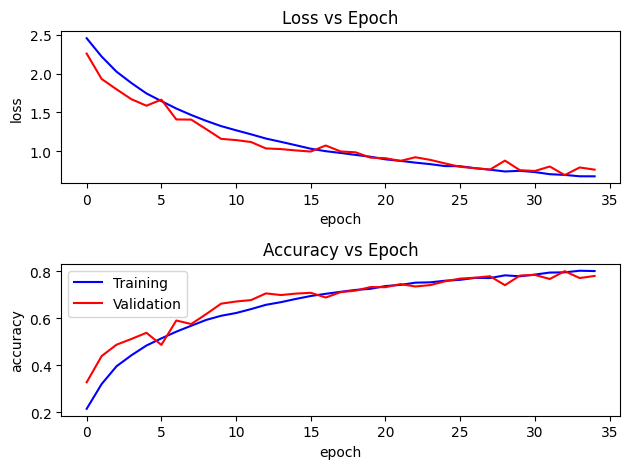

In [17]:
fig, ax = plt.subplots(2,1)
#plot loss
ax[0].set_title('Loss vs Epoch')
ax[0].plot(history.history['loss'],color='b',label='Training')
ax[0].plot(history.history['val_loss'],color='r',label='Validation')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
#plot accuracy
ax[1].set_title('Accuracy vs Epoch')
ax[1].plot(history.history['accuracy'],color='b',label='Training')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
plt.legend()
fig.tight_layout()

In [18]:
score = cnn.evaluate(test_ds)

83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8164 - loss: 0.6749


In [19]:
from tensorflow.nn import softmax
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Confusion matrix and Other Measurements

In [20]:

logits = cnn.predict(test_ds)
pred = softmax(logits).numpy()
y_pred = np.argmax(pred, axis = 1)
y_actual = np.argmax(np.concatenate([y for x, y in test_ds], axis = 0), axis = 1)
matrix = multilabel_confusion_matrix(y_pred, y_actual, labels = range(10))


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


2024-12-18 13:21:42.787085: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
print("\t   Confusion Matrix\n ")

for i in range(10):
    print('--------------' + classes[i] + ' class' + '--------------')
    print(f"True positive: {matrix[i][1][1]} False Negative: {matrix[i][1][0]}")
    print(f"False positive: {matrix[i][0][1]} True Negative: {matrix[i][0][0]}")
    print()

	   Confusion Matrix
 
--------------Dog class--------------
True positive: 372 False Negative: 56
False positive: 115 True Negative: 2082

--------------Horse class--------------
True positive: 216 False Negative: 72
False positive: 47 True Negative: 2290

--------------Elephant class--------------
True positive: 107 False Negative: 33
False positive: 38 True Negative: 2447

--------------Butterfly class--------------
True positive: 184 False Negative: 42
False positive: 28 True Negative: 2371

--------------Chicken class--------------
True positive: 285 False Negative: 86
False positive: 26 True Negative: 2228

--------------Cat class--------------
True positive: 127 False Negative: 33
False positive: 41 True Negative: 2424

--------------Cow class--------------
True positive: 118 False Negative: 55
False positive: 69 True Negative: 2383

--------------Sheep class--------------
True positive: 125 False Negative: 53
False positive: 57 True Negative: 2390

--------------Spider class---

In [22]:
#print precision, recall and f1 for each class
print(classification_report(y_pred, y_actual, target_names=classes))

              precision    recall  f1-score   support

         Dog       0.76      0.87      0.81       428
       Horse       0.82      0.75      0.78       288
    Elephant       0.74      0.76      0.75       140
   Butterfly       0.87      0.81      0.84       226
     Chicken       0.92      0.77      0.84       371
         Cat       0.76      0.79      0.77       160
         Cow       0.63      0.68      0.66       173
       Sheep       0.69      0.70      0.69       178
      Spider       0.92      0.91      0.92       487
    Squirrel       0.77      0.83      0.80       174

    accuracy                           0.81      2625
   macro avg       0.79      0.79      0.79      2625
weighted avg       0.81      0.81      0.81      2625



# Prediction

In [23]:
it = test_ds.as_numpy_iterator()

In [24]:
image, label = next(it) # iterate to each batch
#get the first 5 images from each batch
num_im = 5
logits = cnn.predict(image[:num_im])
pred = softmax(logits)
actual = np.argmax(label[:num_im], axis = 1)
pred = np.argmax(pred, axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


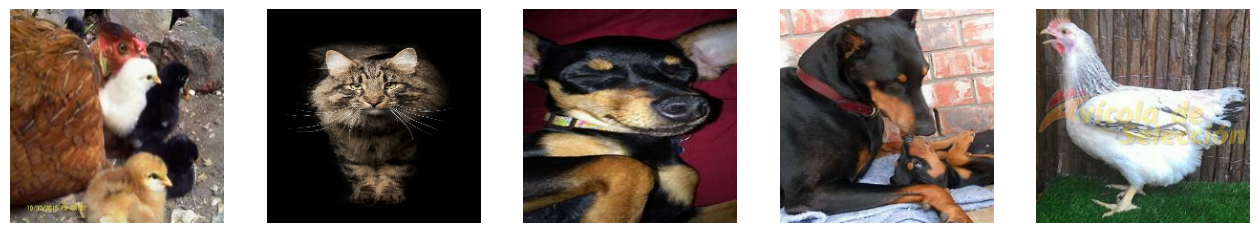

In [25]:
plt.figure(figsize=(16, 16))
for i in range(5):
    plt.subplot(1,5, i + 1)
    plt.imshow(image[i].astype('uint8'))
    plt.axis('off')
plt.show()

In [26]:
print('Prediction: ', str(np.array(classes)[pred]))
print('True Label: ', str(np.array(classes)[actual]))

Prediction:  ['Chicken' 'Cat' 'Dog' 'Dog' 'Chicken']
True Label:  ['Chicken' 'Cat' 'Dog' 'Dog' 'Chicken']
